# Efficient Fine-tune of BLIP-2 on Food Captions with Huggingface PEFT

#### Reference:
https://github.com/huggingface/notebooks/blob/main/peft/Fine_tune_BLIP2_on_an_image_captioning_dataset_PEFT.ipynb

https://github.com/huggingface/peft/blob/main/examples/int8_training/fine_tune_blip2_int8.py

https://discuss.huggingface.co/t/finetune-blip-on-customer-dataset-20893/28446/13

https://github.com/salesforce/LAVIS/blob/main/lavis/common/optims.py


## Setup

In [1]:
!pip install transformers bitsandbytes datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00


In [2]:
!pip install peft==0.6.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 24.2 MB/s eta 0:00:00


## Load dataset

In [3]:
from datasets import load_dataset
dataset = load_dataset("advancedcv/Food500Cap",split="train")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/19877 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4938 [00:00<?, ? examples/s]

In [4]:
# Challenging labels to evaluate on, exclude them from training set
label_set = {"Aloo_gobi","Baingan_bharta","Chakli","Sambar","Vindaloo","Bon_bon_chicken",
             "Chinese_chicken_salad","Shanghai_fried_noodles","Taro_dumpling","Wonton_noodles",
             "Katsudon","Soba","Tonkotsu_ramen"}

In [5]:
idx_list_train = []
for i in range(len(dataset)):
  data = dataset[i]
  if(data["cat"] not in label_set):
    idx_list_train.append(i)

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [6]:
print(len(dataset))

19877


In [7]:
import numpy as np
print("Number of original labels", len(np.unique(dataset["cat"])))

Number of original labels 514


In [8]:
# Get training dataset after excluding challenging labels
dataset = dataset.select(idx_list_train)

In [9]:
print(len(dataset))

19357


In [10]:
print("Number of included labels", len(np.unique(dataset["cat"])))

Number of included labels 501


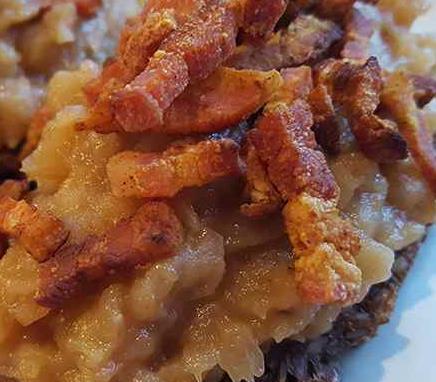

In [11]:
dataset[0]["image"]

In [12]:
dataset[0]["caption"]

'A plate of AEbleflaesk with red fully-roasted crispy pork belly and yellow apple puree.'

## Create PyTorch Dataset

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        transforms = v2.Compose([
          v2.RandomResizedCrop(size=(364, 364),scale=(0.75, 1.0), antialias=True),
          v2.RandomHorizontalFlip(p=0.5),
        ])
        image = transforms(image)
        encoding = self.processor(images=image, padding=True, return_tensors="pt",
                                  do_resize=True, size=(364,364),do_normalize = True)
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["caption"] = item["caption"]
        return encoding

def collate_fn(batch):
  # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "caption":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["caption"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

## Load Model

In [14]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b",torch_dtype = torch.float16)

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Convert loaded model to PEFT for Lora fine-tuning

In [15]:
from peft import LoraConfig, get_peft_model

# Configureation for Lora
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj","v_proj","fc2","lm_head"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 19,975,680 || all params: 3,764,655,616 || trainable%: 0.5306110847192032


## Fine-tuning

In [16]:
import random
import numpy as np
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

In [17]:
import math
# Define cosine annealing learning rate scheduler with linear warmup
class LinearWarmupCosineLRSchedulerWithRestart:
    def __init__(self, optimizer, max_epoch, min_lr, init_lr, restart_step,warmup_steps=0, warmup_start_lr=-1):
        self.optimizer = optimizer

        self.max_epoch = max_epoch
        self.min_lr = min_lr

        self.init_lr = init_lr
        self.warmup_steps = warmup_steps
        self.warmup_start_lr = warmup_start_lr if warmup_start_lr >= 0 else init_lr
        self.restart_step = restart_step

    def step(self, cur_epoch, cur_step):
        # assuming the warmup iters less than one epoch
        if cur_epoch == 0:
            warmup_lr_schedule(
                step=cur_step,
                optimizer=self.optimizer,
                max_step=self.warmup_steps,
                init_lr=self.warmup_start_lr,
                max_lr=self.init_lr,
            )
        else:
            cosine_lr_schedule(
                epoch=cur_epoch % self.restart_step,
                optimizer=self.optimizer,
                max_epoch=self.max_epoch,
                init_lr=self.init_lr,
                min_lr=self.min_lr,
            )

def cosine_lr_schedule(optimizer, epoch, max_epoch, init_lr, min_lr):
    """Decay the learning rate"""
    lr = (init_lr - min_lr) * 0.5 * (
        1.0 + math.cos(math.pi * epoch / max_epoch)
    ) + min_lr
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def warmup_lr_schedule(optimizer, step, max_step, init_lr, max_lr):
    """Warmup the learning rate"""
    lr = min(max_lr, init_lr + (max_lr - init_lr) * step / max(max_step, 1))
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [18]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16, collate_fn=collate_fn)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
scheduler = LinearWarmupCosineLRSchedulerWithRestart(optimizer,max_epoch = 10, min_lr = 0,
                                          init_lr = 3e-5,warmup_steps=1000,warmup_start_lr=1e-8,
                                                     restart_step=10)
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epochs = 30

# Gradient accumulation to accomodate small GPU VRam
gradient_accumulation_steps = 2

model.to(device)
for epoch in range(num_epochs):
  # Training phase
  model.train()
  train_loss = 0
  for idx, batch in enumerate(train_dataloader):
      scheduler.step(cur_epoch = epoch, cur_step = idx)
      input_ids = batch.pop("input_ids").to(device)
      pixel_values = batch.pop("pixel_values").to(device)
      with torch.autocast(device_type='cuda', dtype=torch.float16):
        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)
      loss = outputs.loss
      loss = loss / gradient_accumulation_steps
      loss.backward()
      train_loss += loss.item()
      if ((idx + 1) % gradient_accumulation_steps == 0) or ((idx + 1)== len(train_dataloader)):
        optimizer.step()
        optimizer.zero_grad()
      if idx % 100 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{idx + 1}/{len(train_dataloader)}],\
        Training Loss: {train_loss/(idx+1):.7f}, Learning rate:{optimizer.param_groups[0]['lr']:.7f}")
  torch.cuda.empty_cache()

Epoch [1/30], Step [1/1210],        Training Loss: 2.7951818, Learning rate:0.0000000


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1/30], Step [101/1210],        Training Loss: 2.9035072, Learning rate:0.0000030
Epoch [1/30], Step [201/1210],        Training Loss: 2.7170062, Learning rate:0.0000060
Epoch [1/30], Step [301/1210],        Training Loss: 2.4824952, Learning rate:0.0000090
Epoch [1/30], Step [401/1210],        Training Loss: 2.2148908, Learning rate:0.0000120
Epoch [1/30], Step [501/1210],        Training Loss: 1.9774698, Learning rate:0.0000150
Epoch [1/30], Step [601/1210],        Training Loss: 1.8053283, Learning rate:0.0000180
Epoch [1/30], Step [701/1210],        Training Loss: 1.6749059, Learning rate:0.0000210
Epoch [1/30], Step [801/1210],        Training Loss: 1.5738356, Learning rate:0.0000240
Epoch [1/30], Step [901/1210],        Training Loss: 1.4918783, Learning rate:0.0000270
Epoch [1/30], Step [1001/1210],        Training Loss: 1.4230004, Learning rate:0.0000300
Epoch [1/30], Step [1101/1210],        Training Loss: 1.3675111, Learning rate:0.0000300
Epoch [1/30], Step [1201/1210]

In [19]:
# Check training results
inputs = processor(images=dataset[0]["image"], return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values
generated_ids = model.generate(pixel_values=pixel_values, max_new_tokens=30)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

A plate of AEbleflaesk with a lot of bacon on top.


## Upload fine-tuned model to Huggingface



In [22]:
from huggingface_hub import notebook_login
notebook_login()
model.push_to_hub("advancedcv/blip2-opt-2.7b_Food500Cap_finetuned_challenging")

adapter_model.safetensors:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/advancedcv/blip2-opt-2.7b_Food500Cap_finetuned_challenging/commit/eb10a6e2af94753a5d93bf063d9e0894667095b3', commit_message='Upload model', commit_description='', oid='eb10a6e2af94753a5d93bf063d9e0894667095b3', pr_url=None, pr_revision=None, pr_num=None)